# **Exploring Multi-Modal Retrieval with 4M**  

In this second part of the 4M tutorial, you will learn how to use the 4M model for multi-modal retrieval.  

The key idea behind multi-modal retrieval is to map one or multiple input modalities (such as image, text, or semantic segmentation) into a shared latent feature space. By computing distances between these feature representations, we can find examples that exhibit high similarity.  

In this notebook, we achieve multi-modal retrieval by mapping input modalities into the **feature space** of [DINOv2](https://arxiv.org/abs/2304.07193) or [ImageBind](https://arxiv.org/abs/2305.05665). These models are known for learning powerful representations and were used as one of the modalities during **4M pretraining**, allowing us to leverage them as target modalities for retrieval by predicting them from arbitrary inputs.

Follow the steps in this notebook to understand the **multi-modal retrieval process** and complete the hands-on practice at the end.

The setup in this notebook is similar to the one from the first notebook.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
from matplotlib import gridspec

try:
    import faiss
except:
    print('Please install faiss via pip install faiss-gpu to perform retrieval.')

from fourm.models.fm import FM
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality, custom_text
from fourm.data.modality_transforms import RGBTransform
from fourm.data.modality_info import MODALITY_INFO
from fourm.data.modality_transforms import MetadataTransform
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square, decode_tok_depth, decode_tok_semseg

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

xFormers not available
xFormers not available
No module named 'smplx'
Human pose dependencies are not installed, hence poses will not be visualized. To visualize them (optional), you can do the following: 
1) Install via `pip install timm yacs smplx pyrender pyopengl==3.1.4` 
   You may need to follow the pyrender install instructions: https://pyrender.readthedocs.io/en/latest/install/index.html 
2) Download SMPL data from https://smpl.is.tue.mpg.de/. See https://github.com/shubham-goel/4D-Humans/ for an example. 
3) Copy the required SMPL files (smpl_mean_params.npz, SMPL_to_J19.pkl, smpl/SMPL_NEUTRAL.pkl) to fourm/utils/hmr2_utils/data .


/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


### Load tokenizers

To encode modalities into discrete tokens, and in turn decode the tokens that 4M predicts, we use modality-specific tokenizers. We can easily load them from [Hugging Face hub](https://huggingface.co/EPFL-VILAB) with the below lines.

The tokenizer checkpoint names are formated as: `f'4M_tokenizers_{modality}_{vocab_size}_{min_res}-{max–res}'`.
All tokenizers here are trained to work on resolutions between 224 and 448, in steps of 32.

In [3]:
text_tok = Tokenizer.from_file('toks/text_tokenizer_4m_wordpiece_30k.json')

toks = {
    'tok_depth': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_depth_8k_224-448').eval().to(device),
    'tok_semseg': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').eval().to(device),
    'tok_dinov2_global': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_DINOv2-B14-global_8k_16_224').eval().to(device),
}

### Load a 4M-21 model

Let's load a 4M-21 XL model that was trained on 21 modalities, including RGB, depth, surface normals, semantic segmentation, SAM instances, Canny & SAM edges, 3D human poses, CLIP-B/16 features, DINOv2-B/14 features, ImageBind-H/14 features, captions, metadata, color palette and bounding boxes. It can take any combination of those modalities as input, and can predict all of them. We wrap the model in a `GenerationSampler` which provides inference utilities.

Please see [official repo's](https://github.com/apple/ml-4m) `README.md` for all available 4M and tokenizer models.

In [4]:
fm = FM.from_pretrained('EPFL-VILAB/4M-21_B').eval().to(device)
sampler = GenerationSampler(fm)

### RGB → DINOv2 global embedding

Given an RGB input, predict DINOv2. Inference/generation is done by providing a _generation schedule_ to the `GenerationSampler`. 
A _generation schedule_ specifies the order of modalities to generate, and for each it contains the generation parameters like number of steps or temperature.
We provide a convenience function `build_chained_generation_schedules` that allows for building arbitrary chained generation schedules.
We call it chained generation, since every newly generated output is looped back into the input and serves as conditioning for subsequently generated modalities.
This enables generating multiple modalities that are all consistent with each other, which is mostly important when the conditioning is underspecified.
Please see the generation notebook and the paper for more details on chained generation.

The `build_chained_generation_schedules` function takes several inputs. 
Please see the generation README in [`README_GENERATION.md`](https://github.com/apple/ml-4m/blob/main/README_GENERATION.md) for detailed information on each of them, and tips on how to set them.
In the following, we give an RGB image as input (pixels not tokens), and predict DINOv2 global embeddings from it. Note that while this demo uses an RGB image as input to predict the global embeddings, any other subset of modalities can also be used.

In [5]:
cond_domains = ['rgb@224']
target_domains = ['tok_dinov2_global'] 
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = ['linear']
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  217k  100  217k    0     0  1394k      0 --:--:-- --:--:-- --:--:-- 1394k


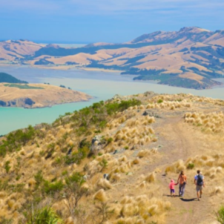

In [6]:
# Download image from the specified URL and preprocess it
image_url = 'https://storage.googleapis.com/four_m_site/images/demo_rgb.png'
!curl $image_url --output input.jpg

rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)
img_pil = rgb_transform.load('./input.jpg')
img_pil = rgb_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((224,224))
img = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
img_pil

In [7]:
# Download retrieval data for depth and semantic segmentation (3.8G)
retrieval_data_url = 'https://datasets.epfl.ch/vilab/retrieval_data_4m/retrieval_data_4m.tar.gz'
!curl $retrieval_data_url --output retrieval_data_4m.tar.gz
!tar -xvf retrieval_data_4m.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3003M  100 3003M    0     0  18.6M      0  0:02:40  0:02:40 --:--:-- 25.4M
retrieval_data/
retrieval_data/retrieval_set_depth_10k.pth
retrieval_data/retrieval_set_semseg_10k.pth
retrieval_data/depth_tokens_10k.pth
retrieval_data/semseg_tokens_10k.pth


In [8]:
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

Now we are ready to perform the generation. The `GenerationSampler` has a `.generate` function that performs the chained generation on a given sample dictionary, following the previously specified generation schedule.
It outputs a dictionary that is formatted in the same manner as the sample dictionary, but contains also the predicted tokens. You can change the seed to get different outputs, or set it to None to randomly sample.

4M / the sampler outputs discrete tokens, and we still need to decode them to images, feature maps, text, etc using the modality-specific tokenizers. 
For that, we provide the `decode_dict` function that takes as input the sample dictionary and the tokenizers, and returns plottable representations of each modality.
Some modalities like RGB, depth and normals use a diffusion model as the tokenizer decoder. You can specify the number of DDIM steps for decoding with `decoding_steps`.

In [9]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00,  1.45it/s]


Load depth retrieval set and tokens.  

In [10]:
depth_retrieval_set_embeddings = torch.load('./retrieval_data/retrieval_set_depth_10k.pth')
depth_retrieval_set_tokens = torch.load('./retrieval_data/depth_tokens_10k.pth')

Given the global embedding predicted for the query and retrieval set, now we can perform retrieval by comparing their cosine distances.

/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/scheduling/diffusion_pipeline.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


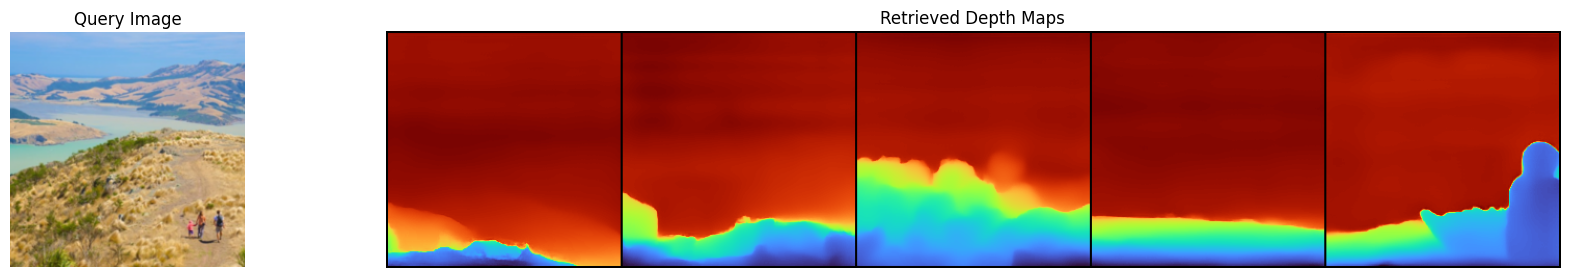

In [11]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(depth_retrieval_set_embeddings.size(1))
index.add(depth_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(dec_dict[cond_domains[0]], cmap='gray')
ax0.set_title("Query Image")
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = depth_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_depth(batched_sample, toks, 'tok_depth@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Depth Maps")
ax1.axis('off')
plt.show()


Let's do the same to retrieve semantic segmentation maps.
First load the retrieval set embeddings and tokens.

In [12]:
semseg_retrieval_set_embeddings = torch.load('./retrieval_data/retrieval_set_semseg_10k.pth')
semseg_retrieval_set_tokens = torch.load('./retrieval_data/semseg_tokens_10k.pth')

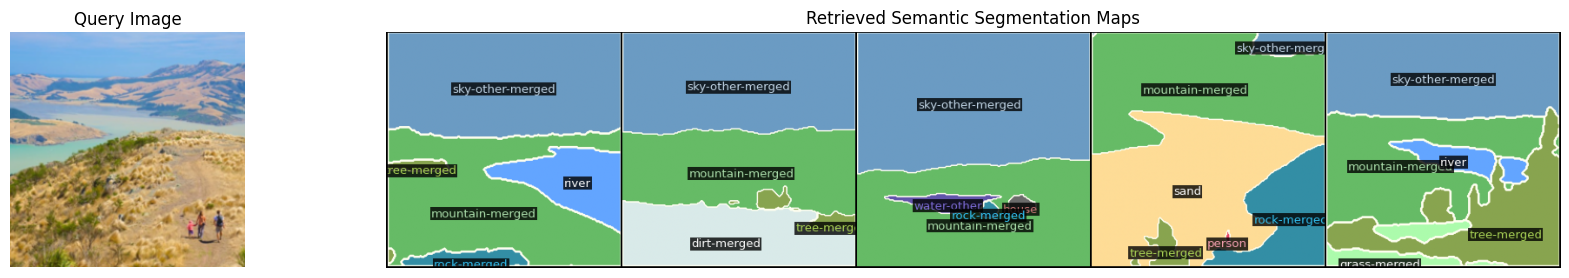

In [13]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(dec_dict[cond_domains[0]], cmap='gray')
ax0.set_title("Query Image")
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()


### Caption + Metadata → DINOv2 global embedding

Alternatively, we can use multimodal input (e.g. a caption and metadata) to perform retrieval.

In [14]:
cond_domains = ['caption', 'metadata']
target_domains = ['tok_dinov2_global']
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

In [15]:
caption = 'hiking in the mountains on a sunny day' 
metadata_transform = MetadataTransform(shuffle=False, random_trunc=False, return_chunks=False)
metadata_dict = {
    'semantic_diversity': 2,
}
metadata_str = metadata_transform.metadata_to_string(metadata_dict) + ' [S_1]'


batched_sample = {}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)

batched_sample = custom_text(batched_sample, input_text=caption, text_tokenizer=text_tok, eos_token='[EOS]', key='caption', device=device, target_max_len=256, start_token='[S_1]')
batched_sample = custom_text(batched_sample, input_text=metadata_str, text_tokenizer=text_tok, eos_token='[EOS]', key='metadata', device=device)


In [16]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 45.32it/s]


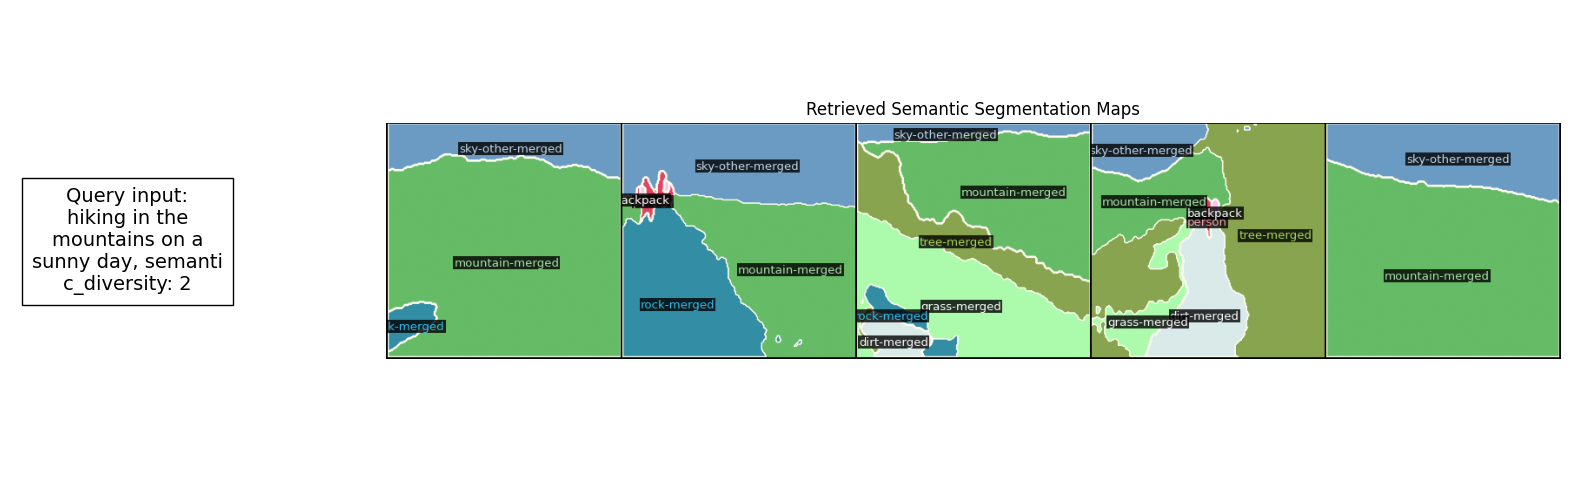

In [17]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
metadata_text = ',\n'.join([f'{k}: {v:.2f}' if isinstance(v, float) else f'{k}: {v}' for k, v in metadata_dict.items()])
plot_text_in_square(ax0, "Query input: " + caption + ", " + metadata_text, wrap_width=18, fontsize=14)
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()


Let's increase the semantic diversity of the scene.

In [18]:

caption = 'hiking in the mountains on a sunny day' 
metadata_transform = MetadataTransform(shuffle=False, random_trunc=False, return_chunks=False)
metadata_dict = {
    'semantic_diversity': 20,
}
metadata_str = metadata_transform.metadata_to_string(metadata_dict) + ' [S_1]'


batched_sample = {}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)

batched_sample = custom_text(batched_sample, input_text=caption, text_tokenizer=text_tok, eos_token='[EOS]', key='caption', device=device, target_max_len=256, start_token='[S_1]')
batched_sample = custom_text(batched_sample, input_text=metadata_str, text_tokenizer=text_tok, eos_token='[EOS]', key='metadata', device=device)


In [19]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 49.37it/s]


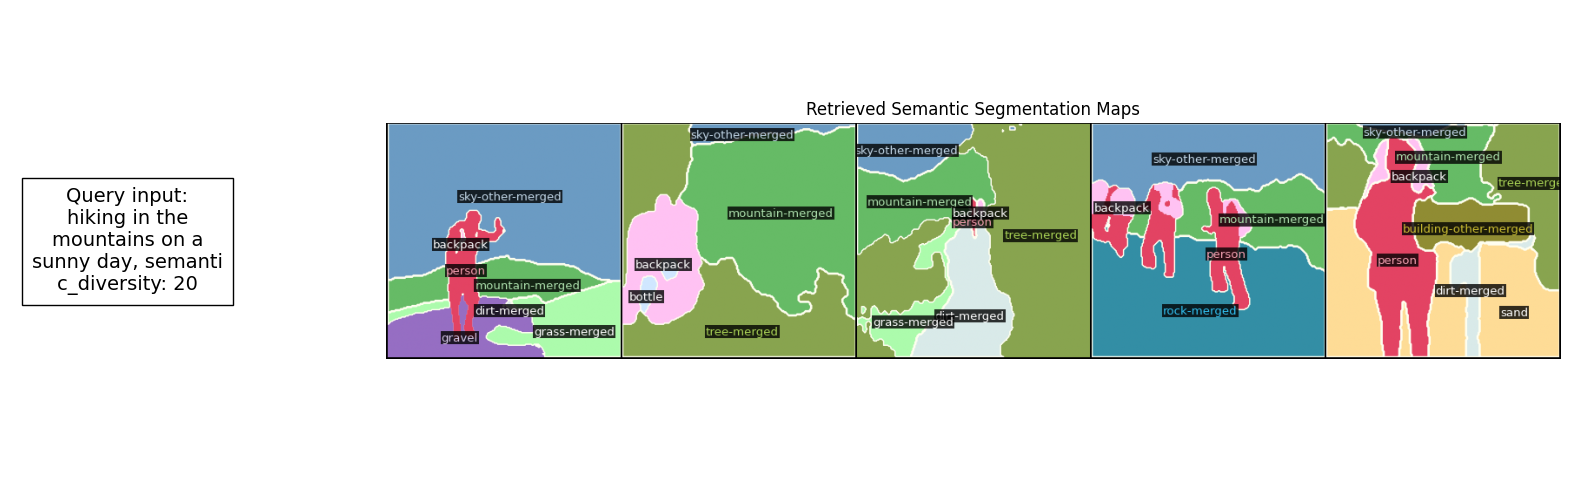

In [20]:
# Create an index for the retrieval features
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_feature.reshape(1, -1), k)
# The 'indices' variable now contains the indices of the k most similar images

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
metadata_text = ',\n'.join([f'{k}: {v:.2f}' if isinstance(v, float) else f'{k}: {v}' for k, v in metadata_dict.items()])
plot_text_in_square(ax0, "Query input: " + caption + ", " + metadata_text, wrap_width=18, fontsize=14)
ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()

# Excercise Session

By now, you should have a basic understanding of what multimodal retrieval means and how to use 4M to perform multimodal retrieval.

To ensure your comprehension, we have provided two exercises. Follow the instructions below, using code cell blocks for code implementations (ensure they are reproducible without errors) and markdown blocks for explanations and discussions.

## Exercise 1: Design Your Own Multimodal Retrieval Queries [10 Points]

1. Design and implement at least **three** different query input approaches to retrieve **semantic segmentation masks that contain cats**. (*3 points for each approach.*)
- Each approach should use a different modality or combination of modalities.
- For each approach, provide **10** retrieved examples.

2. Discussion: Compare the different query inputs. Are the retrieved results similar? What differences do you observe? (*1 point*)

Hints: You can use queries based on text, metadata, an image, a semantic segmentation mask, or a combination of these methods. Feel free to explore different text prompts and use any image from the internet for retrieval!

**Grading:** To receive full points, ensure your code is reproducible and displays both your query and retrieved images at the end of each approach.

### Approach 1: (3 points)

(Briefly describe your approach here. Which modality or combination of modalities are you using?)



In the first approach, I will use text('caption') as an input

In [21]:
# To help structure your answer, we provide a code framework for the first approach. Please complete the missing sections.

# 1. Define input and output modalities

cond_domains =  ['caption']
target_domains = ['tok_dinov2_global'] 
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

In [22]:
# 2. Create your input data

batched_sample = {
}

caption = "A cat is sitting inside a box."

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities 
batched_sample = custom_text(
    batched_sample,
    input_text=caption,
    text_tokenizer=text_tok,
    eos_token='[EOS]',
    key='caption',
    device=device,
    target_max_len=256,
    start_token='[S_1]'
)

In [23]:
# 3. Get the model prediction

out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 49.06it/s]


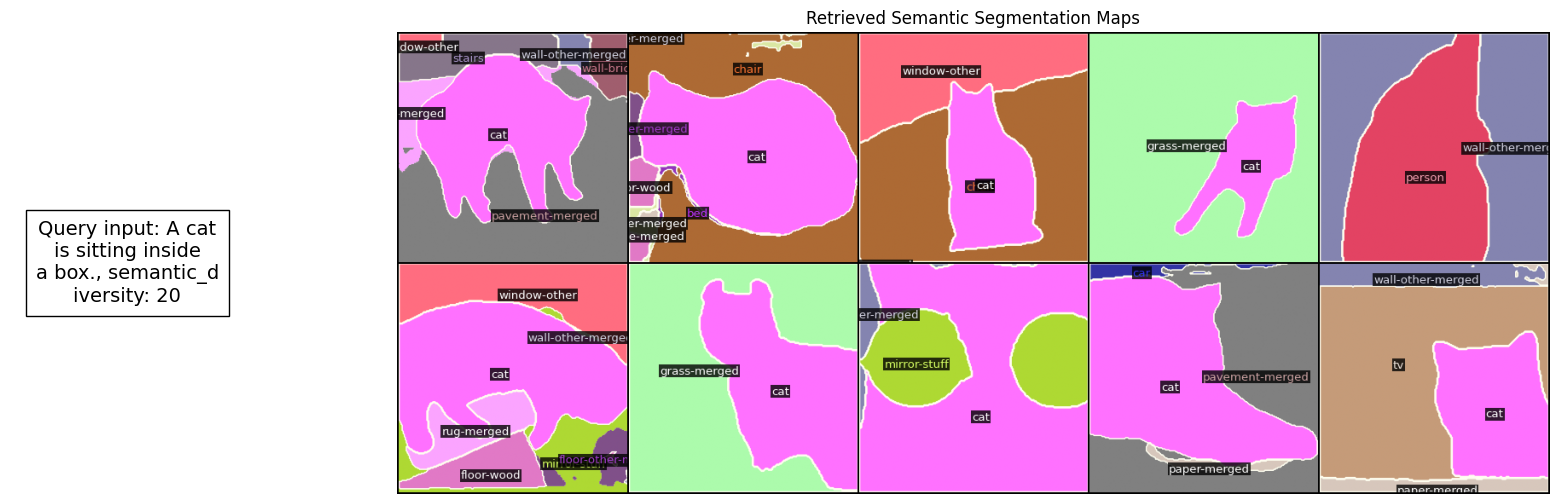

In [24]:
# 4. Do the retrieval and display
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k =  10 # [FILL IN HERE]
distances, indices = index.search(query_feature.reshape(1, -1), k)

# Display the query image
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
plot_text_in_square(ax0, "Query input: " + metadata_text, wrap_width=18, fontsize=14)
ax0.axis('off')
# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()

### Approach 2 (3 points)
(Briefly describe your approach here. Which modality or combination of modalities are you using?)

In the second approach, I will use metadata as an input

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5365  100  5365    0     0  38049      0 --:--:-- --:--:-- --:--:-- 38049


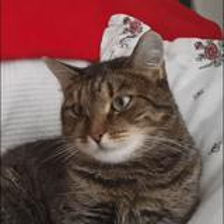

In [31]:
cat_image_url = 'https://i.imgur.com/fqd9uUjb.jpg'
!curl $cat_image_url --output cat.jpg

rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)
img_pil = rgb_transform.load('./cat.jpg')
img_pil = rgb_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((224,224))
img = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
img_pil

In [32]:
# Please provide your code below, you may use multiple cells
# 1. Define input and output modalities

cond_domains =  ['rgb@224']
target_domains = ['tok_dinov2_global'] 
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)


In [33]:
# 2. Create your input data

batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities 
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

In [34]:
# 3. Get the model prediction

out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 46.27it/s]


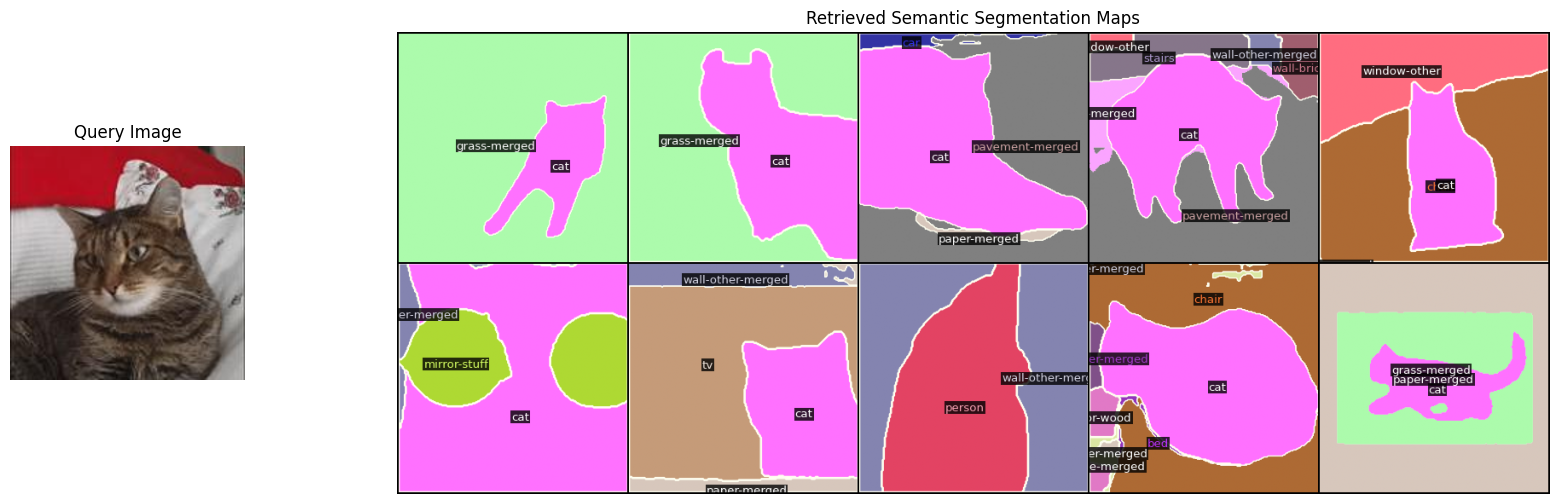

In [35]:
# 4. Do the retrieval and display
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k =  10 # [FILL IN HERE]
distances, indices = index.search(query_feature.reshape(1, -1), k)


plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(dec_dict[cond_domains[0]], cmap='gray')
ax0.set_title("Query Image")
ax0.axis('off')


# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()

### Approach 3 (3 points)
(Briefly describe your approach here. Which modality or combination of modalities are you using?)

n the second approach, I will use metadata and cat image as an input

In [36]:
# Please provide your code below, you may use multiple cells
cond_domains = ['rgb@224', 'metadata']
target_domains = ['tok_dinov2_global']
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)


In [37]:
# 2. Create your input data


metadata_transform = MetadataTransform(shuffle=False, random_trunc=False, return_chunks=False)
metadata_dict = {
    'semantic_diversity': 2,
}
metadata_str = metadata_transform.metadata_to_string(metadata_dict) + ' [S_1]'
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}


# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities

batched_sample = init_full_input_modality(
    batched_sample, MODALITY_INFO, 'rgb@224', 
    device=device, eos_id=text_tok.token_to_id("[EOS]")
)
batched_sample = custom_text(batched_sample, input_text=metadata_str, text_tokenizer=text_tok, eos_token='[EOS]', key='metadata', device=device)


In [38]:
# 3. Get the model prediction

out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [00:00, 47.07it/s]


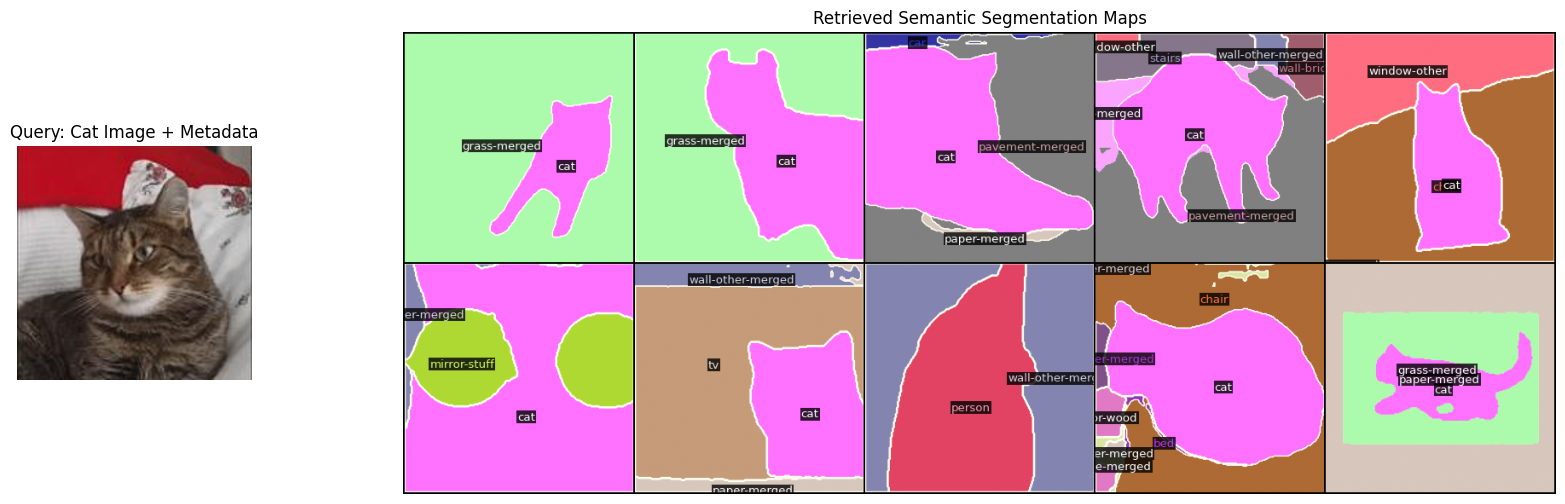

In [39]:
# 4. Do the retrieval and display
index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings.size(1))
index.add(semseg_retrieval_set_embeddings.cpu().numpy())

query_feature = dec_dict['tok_dinov2_global']
query_feature = query_feature.unsqueeze(0).unsqueeze(2).unsqueeze(2).cpu().numpy()

k =  10 # [FILL IN HERE]
distances, indices = index.search(query_feature.reshape(1, -1), k)


plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
ax0.imshow(img_pil)
ax0.set_title("Query: Cat Image + Metadata")
ax0.axis('off')


# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_set_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()

### Discussion (1 point)
Compare the different query inputs. Are the retrieved results similar? What differences do you observe?

For different query inputs, they provide the same result. It was almost impossible to see the difference






## Exercise 2: Using Alternative Deep Features for Retrieval [10 Points]

Beyond DINOv2, the 4M model also supports feature outputs from ImageBind. For this task, use ImageBind to retrieve semantic segmentation masks containing cats from the 10 semseg examples provided below.

Hints:
- Go through the 10 semantic segmentation examples, use the 4M model to get their corresponding deep features, and use them for retrieval.
- For simplicity, feel free to choose any basic input modality, such as text, image, or any other modality you prefer, to complete the task.

**Grading:** To achieve a full score, ensure your code is reproducible and that the final output displays three semantic segmentation images of cats within the given subset (see next block). A 2-point deduction will be applied for each missing cat.

## Data Preparation

In [ ]:
# Please run the code below and review the subset of semantic segmentation tokens.

# The subset of indices for semantic segmentation retrieval
semseg_retrieval_subset_id = [2, 394, 376, 800, 1046, 5000, 6559, 7201, 8945, 9001]
semseg_retrieval_subset_tokens = []
for i in semseg_retrieval_subset_id:
    semseg_retrieval_subset_tokens.append(semseg_retrieval_set_tokens[i])

# Let's visualize the subset
retrieved_images = []
for token in semseg_retrieval_subset_tokens:
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), token, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
plt.figure(figsize=(20,6))
ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Task: Use alternative deep features to find semantic segmentation maps containing cats in the 10 examples.")
ax1.axis('off')
plt.show()

# Your Answer

We provide the partial code below. Please read it carefully and follow the instructions to complete the missing parts.

In [ ]:
# 1. load the semseg and imagebind tokenizers
toks = {
    'tok_semseg': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').eval().to(device),
    'tok_imagebind_global': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_ImageBind-H14-global_8k_16_224').eval().to(device)
    # ...
    # Add any other modality you may need for later use
    
}

In [ ]:
# 2. Iterate through the 10 semantic segmentation images and extract their ImageBind features.

cond_domains = # [FILL IN HERE]
target_domains = # [FILL IN HERE]

tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = ['linear']
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

semseg_retrieval_set_embeddings_imagebind = []


########## [YOUR ANSWER BEGINS] #########
# Extract the ImageBind features for the subset tokens and store them in semseg_retrieval_set_embeddings_imagebind.

for token in semseg_retrieval_subset_tokens:
    # ...




    
########## [YOUR ANSWER ENDS] #########
    


index = faiss.IndexFlatL2(semseg_retrieval_set_embeddings_imagebind.size(1))
index.add(semseg_retrieval_set_embeddings_imagebind.cpu().numpy())

In [ ]:
# 3. Create the query input and extract the corresponding ImageBind features.

cond_domains = #[FILL IN HERE]
target_domains = #[FILL IN HERE]
tokens_per_target = [16]
autoregression_schemes = ['roar']
decoding_steps = [1]
token_decoding_schedules = [ 'linear' ]
temps = [0.1]
temp_schedules = ['constant'] 
cfg_scales = [1.0]
cfg_schedules = ['constant'] 
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

########## [YOUR ANSWER BEGINS] #########
# Design the query input and get the corresponding Imagebind feature





query_feature = 
########## [YOUR ANSWER ENDS] #########

# Do retrieval based on the 
k =  3
distances, indices = index.search(query_feature.reshape(1, -1), k)


In [ ]:
# 4. Visualization

# Display the query 
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5])
ax0 = plt.subplot(gs[0])
# [(OPTIONAL) DISPLAY YOUR QUERY INPUT HERE]
# The query visualization is not graded, but it will make your TA happy by clearly showcasing your method. : )

ax0.axis('off')

# Display the retrieved images
retrieved_images = []
for i in indices[0]:
    batched_sample = semseg_retrieval_subset_tokens[i]
    retrieved_images.append(decode_tok_semseg(np.ones((224, 224, 3)), batched_sample, toks, 'tok_semseg@224'))

denormalized_retrieved_images = [torch.from_numpy(img).permute(2,0,1) for img in retrieved_images] 
retrieved_grid = make_grid(denormalized_retrieved_images, nrow=5)
retrieved_grid = retrieved_grid.permute(1, 2, 0)

ax1 = plt.subplot(gs[1])
ax1.imshow(retrieved_grid)
ax1.set_title("Retrieved Semantic Segmentation Maps")
ax1.axis('off')
plt.show()